This code will load the model information, generate the model definition, and run the model estimation using FSL

In [6]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting

%matplotlib inline
import matplotlib.pyplot as plt

datadir='/home/vagrant/data/ds000114_R2.0.1/'
    
results_dir = os.path.abspath("../../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print('Using data from',datadir)

Using data from /home/vagrant/data/ds000114_R2.0.1/


In [7]:
from bids.grabbids import BIDSLayout
layout = BIDSLayout(datadir)
layout.get(type="bold", task="fingerfootlips", session="test", extensions="nii.gz")[0].filename

'/home/vagrant/data/ds000114_R2.0.1/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz'

In [92]:
import pandas as pd
events = pd.read_csv(os.path.join(datadir, "task-fingerfootlips_events.tsv"), sep="\t")
events

onset  duration  weight trial_type
0      10      15.0       1     Finger
1      40      15.0       1       Foot
2      70      15.0       1       Lips
3     100      15.0       1     Finger
4     130      15.0       1       Foot
5     160      15.0       1       Lips
6     190      15.0       1     Finger
7     220      15.0       1       Foot
8     250      15.0       1       Lips
9     280      15.0       1     Finger
10    310      15.0       1       Foot
11    340      15.0       1       Lips
12    370      15.0       1     Finger
13    400      15.0       1       Foot
14    430      15.0       1       Lips

In [93]:
for trial_type in events.trial_type.unique():
    print(events[events.trial_type == trial_type])

    onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger
    onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot
    onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips


In [94]:
events[events.trial_type == 'Finger'].duration

0     15.0
3     15.0
6     15.0
9     15.0
12    15.0
Name: duration, dtype: float64

In [95]:
source_epi = layout.get(type="bold", task="fingerfootlips", session="test", extensions="nii.gz")[5]

confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-fingerfootlips_bold_confounds.tsv"%(source_epi.subject,
                                                                                                                           source_epi.session)),
           sep="\t", na_values="n/a")

info = [Bunch(conditions=['Finger',
                          'Foot',
                          'Lips'],
              onsets=[list(events[events.trial_type == 'Finger'].onset-10),
                      list(events[events.trial_type == 'Foot'].onset-10),
                      list(events[events.trial_type == 'Lips'].onset-10)],
              durations=[list(events[events.trial_type == 'Finger'].duration),
                          list(events[events.trial_type == 'Foot'].duration),
                          list(events[events.trial_type == 'Lips'].duration)],
             regressors=[list(confounds.FramewiseDisplacement.fillna(0)[4:]),
                         list(confounds.aCompCor0[4:]),
                         list(confounds.aCompCor1[4:]),
                         list(confounds.aCompCor2[4:]),
                         list(confounds.aCompCor3[4:]),
                         list(confounds.aCompCor4[4:]),
                         list(confounds.aCompCor5[4:]),
                        ],
             regressor_names=['FramewiseDisplacement',
                              'aCompCor0',
                              'aCompCor1',
                              'aCompCor2',
                              'aCompCor3',
                              'aCompCor4',
                              'aCompCor5',])
       ]

skip = mem.cache(fsl.ExtractROI)
skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"%(source_epi.subject,
                                                                                                                           source_epi.session)),
                     t_min=4, t_size=-1)

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = skip_results.outputs.roi_file
s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()
s.inputs

170216-19:47:30,476 workflow INFO:
	 Executing node 2173ff0bacc206ded70e35bfa7c6900d in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/2173ff0bacc206ded70e35bfa7c6900d
170216-19:47:30,487 workflow INFO:



event_files = <undefined>
functional_runs = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/2173ff0bacc206ded70e35bfa7c6900d/sub-06_ses-test_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc_roi.nii.gz']
high_pass_filter_cutoff = 128.0
ignore_exception = False
input_units = secs
outlier_files = <undefined>
realignment_parameters = <undefined>
subject_info = [Bunch(conditions=['Finger', 'Foot', 'Lips'], durations=[[15.0, 15.0, 15.0, 15.0, 15.0], [15.0, 15.0, 15.0, 15.0, 15.0], [15.0, 15.0, 15.0, 15.0, 15.0]], onsets=[[0, 90, 180, 270, 360], [30, 120, 210, 300, 390], [60, 150, 240, 330, 420]], regressor_names=['FramewiseDisplacement', 'aCompCor0', 'aCompCor1', 'aCompCor2', 'aCompCor3', 'aCompCor4', 'aCompCor5'], regressors=[[0.16517459999999987, 0.16393550000000012, 0.060880000000000101, 0.099227999999999969, 0.092637999999999998, 0.058773500000000013, 0.08213899999999992, 0.07065919999999988, 0.059915799999999887, 0.040129

In [98]:
finger_cond = ['Finger','T', ['Finger'],[1]]
foot_cond = ['Foot','T', ['Foot'],[1]]
lips_cond = ['Lips','T', ['Lips'],[1]]
lips_vs_others = ["Lips vs. others",'T', ['Finger', 'Foot', 'Lips'],[-0.5, -0.5, 1]]
all_motor = ["All motor", 'F', [finger_cond, foot_cond, lips_cond]]
contrasts=[finger_cond, foot_cond, lips_cond, lips_vs_others, all_motor]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

170216-19:47:45,544 workflow INFO:
	 Executing node 74d7ae2936d9ccca52dab5eb907b61fa in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/74d7ae2936d9ccca52dab5eb907b61fa
170216-19:47:45,558 workflow INFO:



ev_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/74d7ae2936d9ccca52dab5eb907b61fa/ev_Finger_0_1.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/74d7ae2936d9ccca52dab5eb907b61fa/ev_Foot_0_3.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/74d7ae2936d9ccca52dab5eb907b61fa/ev_Lips_0_5.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/74d7ae2936d9ccca52dab5eb907b61fa/ev_FramewiseDisplacement_0_7.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/74d7ae2936d9ccca52dab5eb907b61fa/ev_aCompCor0_0_8.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/74d7ae2936d9ccca52dab5eb907b61fa/ev_aCompCor1_0_9.txt', '/home/vagrant/fmri-analysis

In [99]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

170216-19:47:46,674 workflow INFO:
	 Executing node 8945ac8cd548642ea78bb3a88c03794e in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/8945ac8cd548642ea78bb3a88c03794e
170216-19:47:46,678 workflow INFO:



con_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/8945ac8cd548642ea78bb3a88c03794e/run0.con
design_cov = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/8945ac8cd548642ea78bb3a88c03794e/run0_cov.png
design_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/8945ac8cd548642ea78bb3a88c03794e/run0.mat
design_image = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/8945ac8cd548642ea78bb3a88c03794e/run0.png
fcon_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/8945ac8cd548642ea78bb3a88c03794e/run0.fts

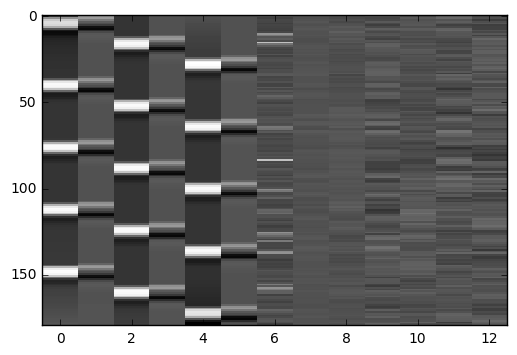

In [100]:
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

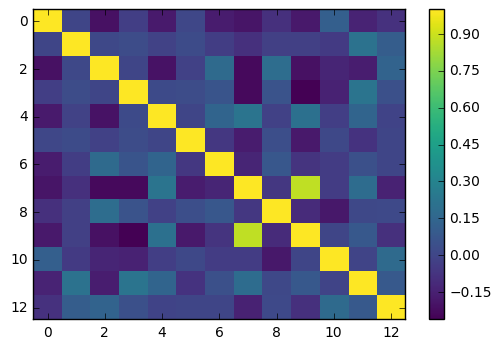

In [101]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()

In [102]:
mask = mem.cache(fsl.maths.ApplyMask)
mask_results = mask(in_file=skip_results.outputs.roi_file,
                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz"%(source_epi.subject,
                                                                                                                             source_epi.session)))
mask_results.outputs

170216-19:47:49,936 workflow INFO:
	 Executing node 6d5befc3d283e8805d34e8668614b457 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/6d5befc3d283e8805d34e8668614b457
170216-19:47:49,944 workflow INFO:



out_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/6d5befc3d283e8805d34e8668614b457/sub-06_ses-test_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc_roi_masked.nii.gz

In [103]:
filmgls= mem.cache(fsl.FILMGLS)
filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
filmgls_results.outputs

170216-19:47:51,7 workflow INFO:
	 Executing node 7f5c5f51c2e4db65146003eb9b361a34 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/7f5c5f51c2e4db65146003eb9b361a34
170216-19:47:51,10 workflow INFO:



copes = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/7f5c5f51c2e4db65146003eb9b361a34/results/cope1.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/7f5c5f51c2e4db65146003eb9b361a34/results/cope2.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/7f5c5f51c2e4db65146003eb9b361a34/results/cope3.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/7f5c5f51c2e4db65146003eb9b361a34/results/cope4.nii.gz']
dof_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/7f5c5f51c2e4db65146003eb9b361a34/results/dof
fstats = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/7f5c5f51c2e4db65146003eb9b361a34/results/fstat1.nii.gz
logfile = /home/vagrant/fmri-analysis-vm/analysis/firs

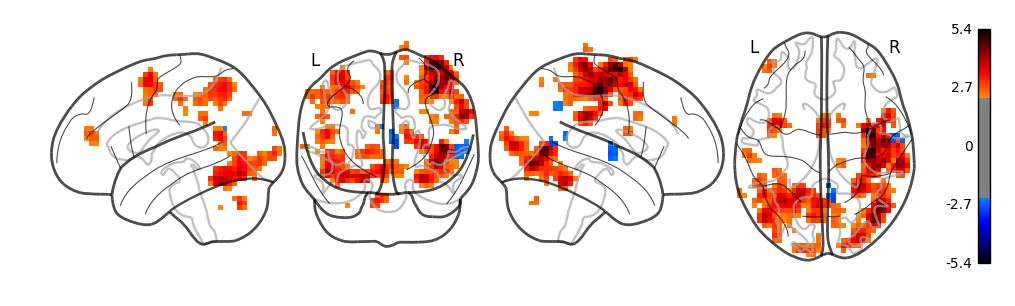

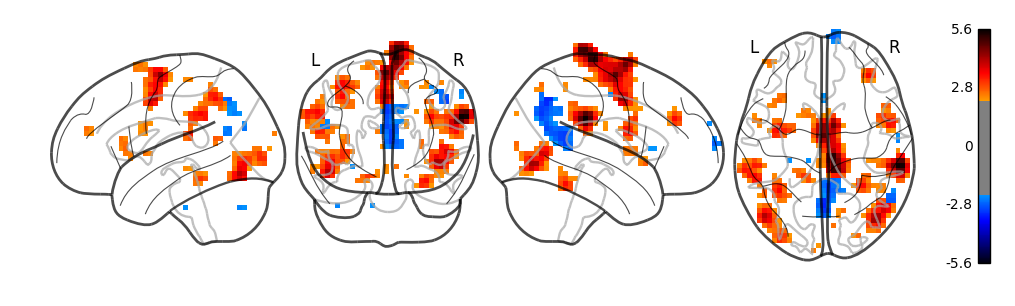

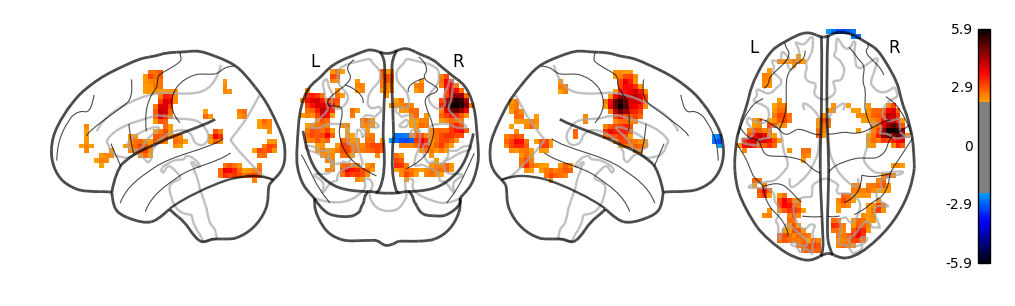

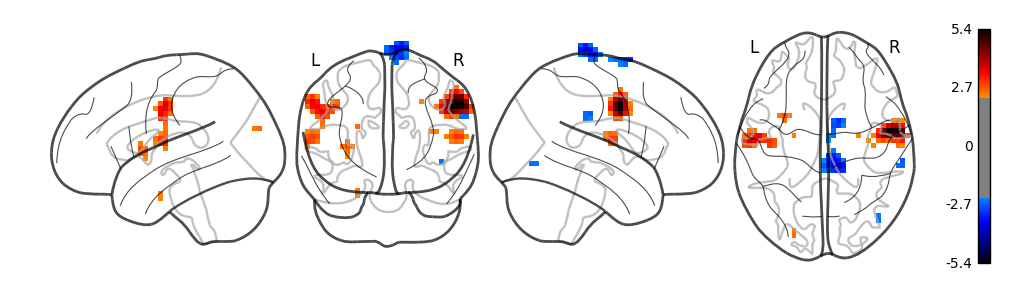

In [104]:
for t_map in filmgls_results.outputs.zstats:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

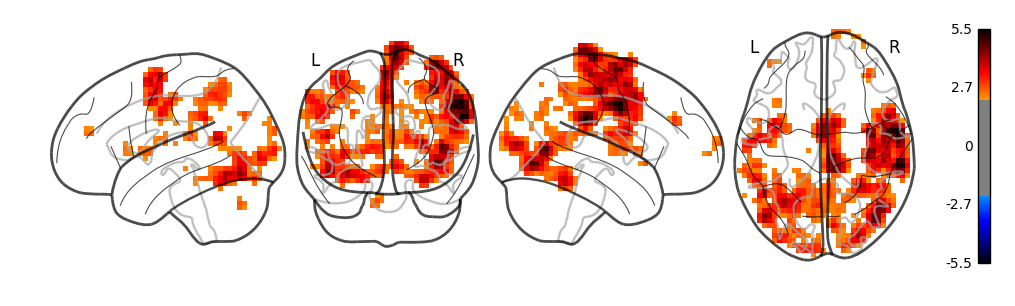

In [105]:
for t_map in [filmgls_results.outputs.zfstats]:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

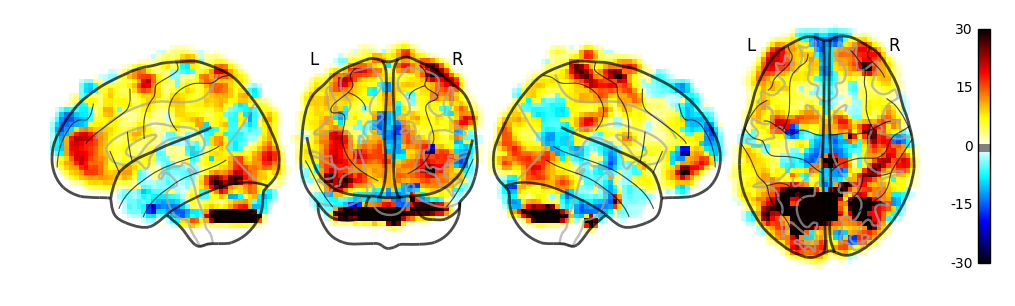

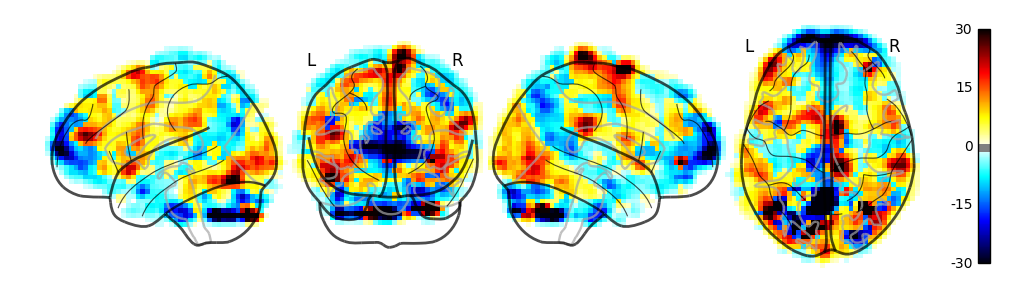

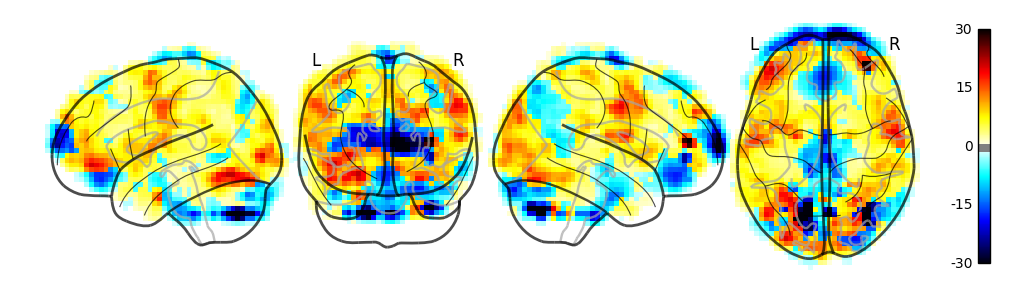

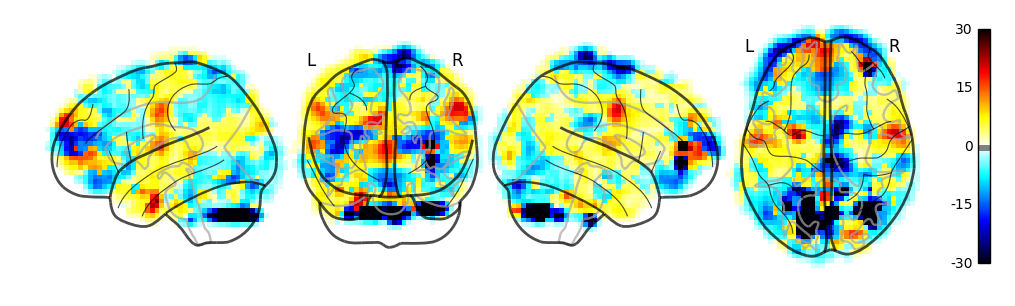

In [106]:
for t_map in filmgls_results.outputs.copes:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, vmax=30)

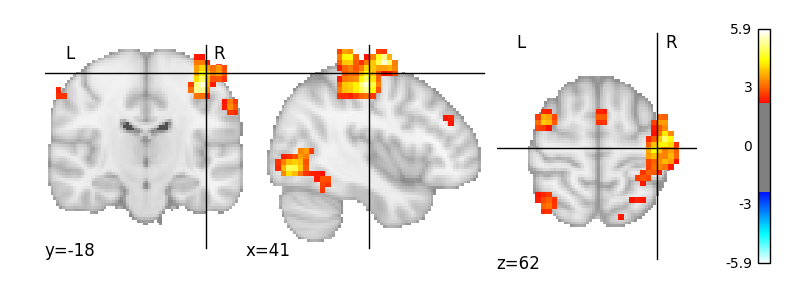

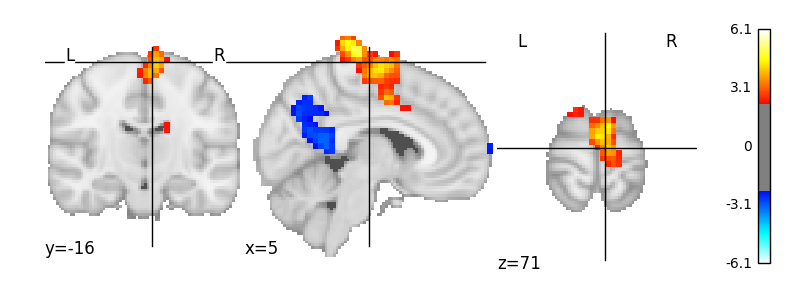

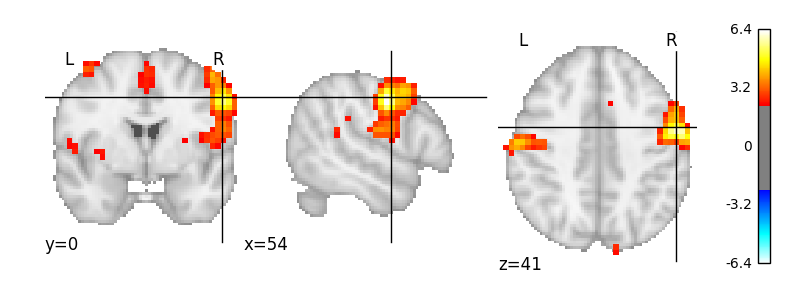

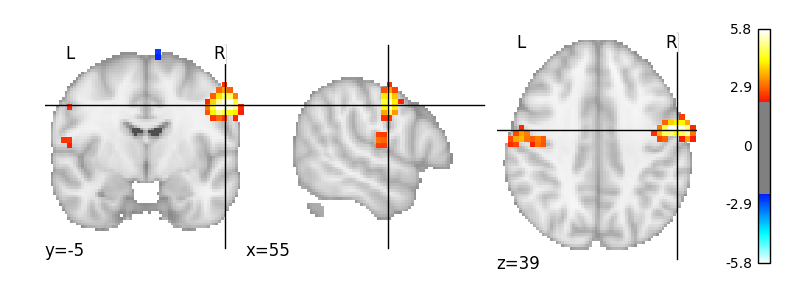

In [107]:
for t_map in filmgls_results.outputs.tstats:
    nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(t_map, 8), colorbar=True, threshold=2.3)

## Repeat for all subjects

For the group level analysis we need to move results from all subjects into one common MNI space. Let's start with the EPI derived mask (we will use it later for group level mask)

In [109]:
copes = {}
for i in range(10):
    source_epi = layout.get(type="bold", task="fingerfootlips", session="test", extensions="nii.gz")[i]

    confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-fingerfootlips_bold_confounds.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
               sep="\t", na_values="n/a")

    info = [Bunch(conditions=['Finger',
                              'Foot',
                              'Lips'],
                  onsets=[list(events[events.trial_type == 'Finger'].onset-10),
                          list(events[events.trial_type == 'Foot'].onset-10),
                          list(events[events.trial_type == 'Lips'].onset-10)],
                  durations=[list(events[events.trial_type == 'Finger'].duration),
                              list(events[events.trial_type == 'Foot'].duration),
                              list(events[events.trial_type == 'Lips'].duration)],
                 regressors=[list(confounds.FramewiseDisplacement.fillna(0)[4:]),
                             list(confounds.aCompCor0[4:]),
                             list(confounds.aCompCor1[4:]),
                             list(confounds.aCompCor2[4:]),
                             list(confounds.aCompCor3[4:]),
                             list(confounds.aCompCor4[4:]),
                             list(confounds.aCompCor5[4:]),
                            ],
                 regressor_names=['FramewiseDisplacement',
                                  'aCompCor0',
                                  'aCompCor1',
                                  'aCompCor2',
                                  'aCompCor3',
                                  'aCompCor4',
                                  'aCompCor5',])
           ]

    skip = mem.cache(fsl.ExtractROI)
    skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"%(source_epi.subject,
                                                                                                                               source_epi.session)),
                         t_min=4, t_size=-1)

    s = model.SpecifyModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = skip_results.outputs.roi_file
    s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.subject_info = info
    specify_model_results = s.run()
    
    finger_cond = ['Finger','T', ['Finger'],[1]]
    foot_cond = ['Foot','T', ['Foot'],[1]]
    lips_cond = ['Lips','T', ['Lips'],[1]]
    lips_vs_others = ["Lips vs. others",'T', ['Finger', 'Foot', 'Lips'],[-0.5, -0.5, 1]]
    all_motor = ["All motor", 'F', [finger_cond, foot_cond, lips_cond]]
    contrasts=[finger_cond, foot_cond, lips_cond, lips_vs_others, all_motor]

    level1design = mem.cache(fsl.model.Level1Design)
    level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                        bases = {'dgamma':{'derivs': True}},
                                        session_info = specify_model_results.outputs.session_info,
                                        model_serial_correlations=True,
                                        contrasts=contrasts)
    
    modelgen = mem.cache(fsl.model.FEATModel)
    modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                                ev_files=level1design_results.outputs.ev_files)
    
    mask = mem.cache(fsl.maths.ApplyMask)
    mask_results = mask(in_file=skip_results.outputs.roi_file,
                        mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz"%(source_epi.subject,
                                                                                                                             source_epi.session)))
    
    filmgls= mem.cache(fsl.FILMGLS)
    filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                              design_file = modelgen_results.outputs.design_file,
                              tcon_file = modelgen_results.outputs.con_file,
                              fcon_file = modelgen_results.outputs.fcon_file,
                              autocorr_noestimate = True)
                                                                                                                             
    copes[source_epi.subject] = list(filmgls_results.outputs.copes)                                                                                                                         



170216-19:48:19,965 workflow INFO:
	 Executing node 174cdf719080398538e308387b24f09e in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/174cdf719080398538e308387b24f09e
170216-19:48:19,970 workflow INFO:
170216-19:48:19,996 workflow INFO:
	 Executing node a386190248c0e00d040c4f2acace5e81 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/a386190248c0e00d040c4f2acace5e81
170216-19:48:20,11 workflow INFO:
170216-19:48:20,19 workflow INFO:
	 Executing node 1edff29b476cd009678abc7a05af37ad in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/1edff29b476cd009678abc7a05af37ad
170216-19:48:20,20 workflow INFO:
170216-19:48:20,35 workflow INFO:
	 Executing node 9874639b92a90656f4d4da94d3cd4fbd in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/9874639b92a90656f4d4da94

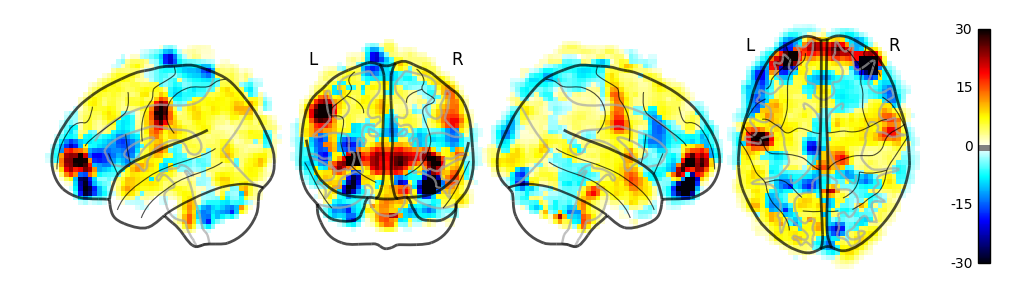

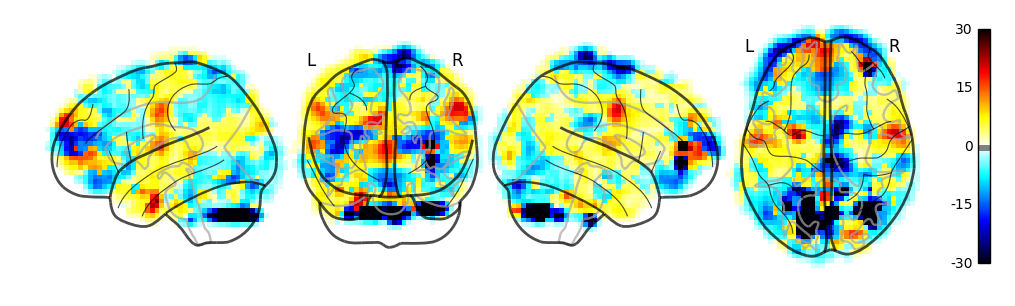

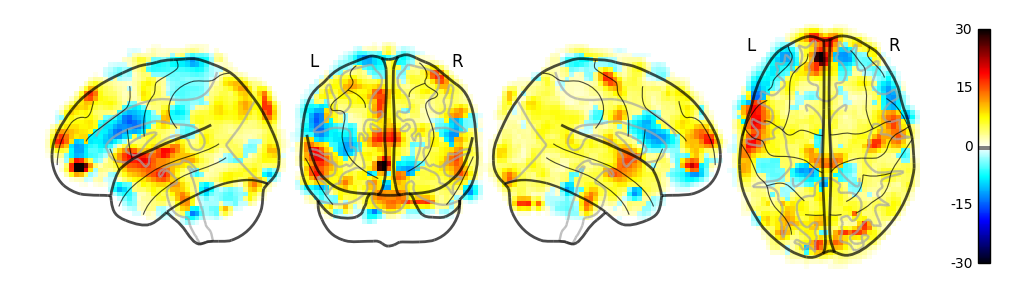

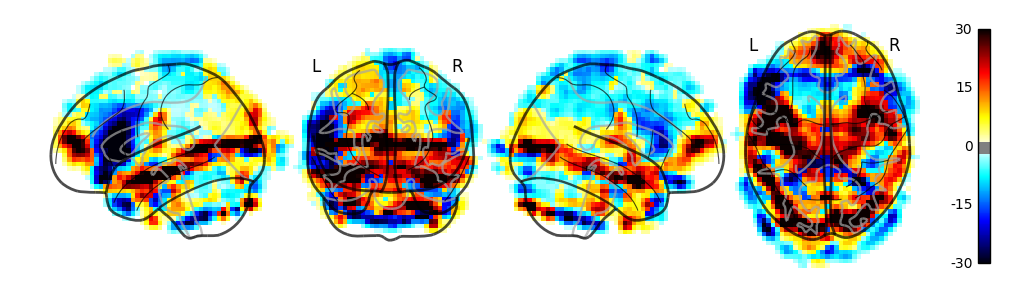

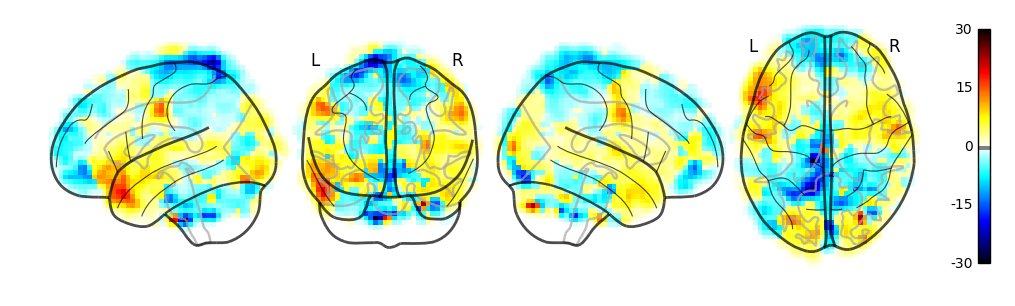

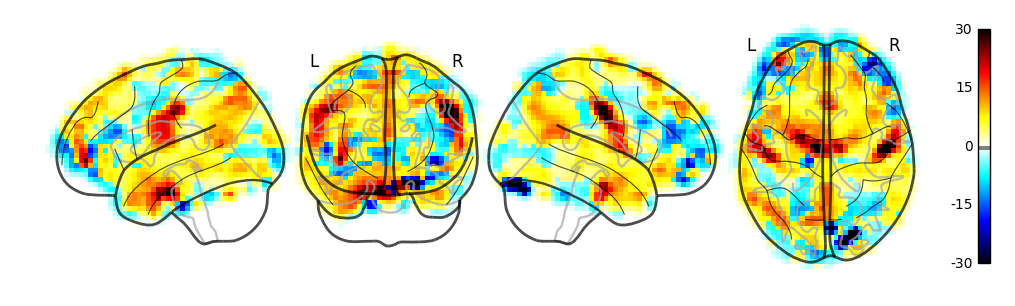

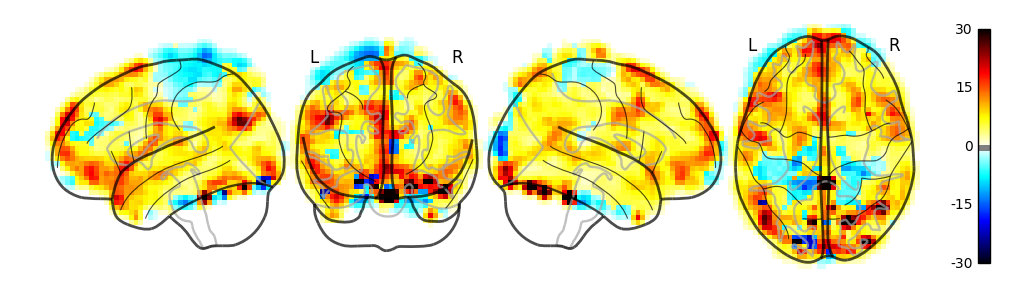

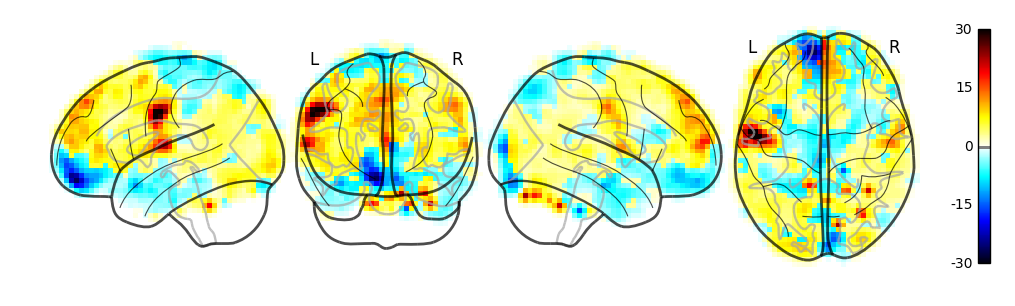

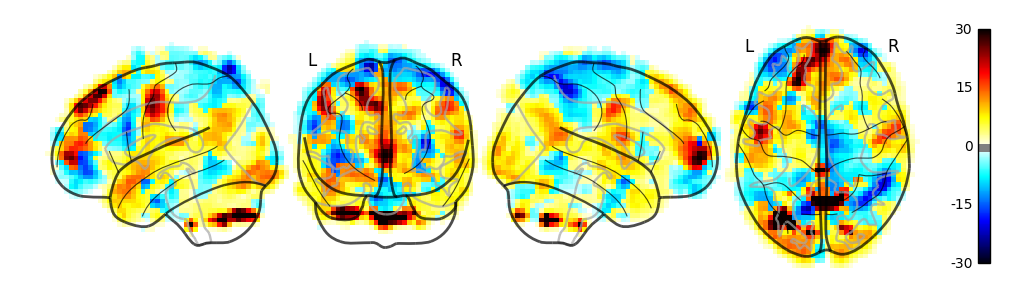

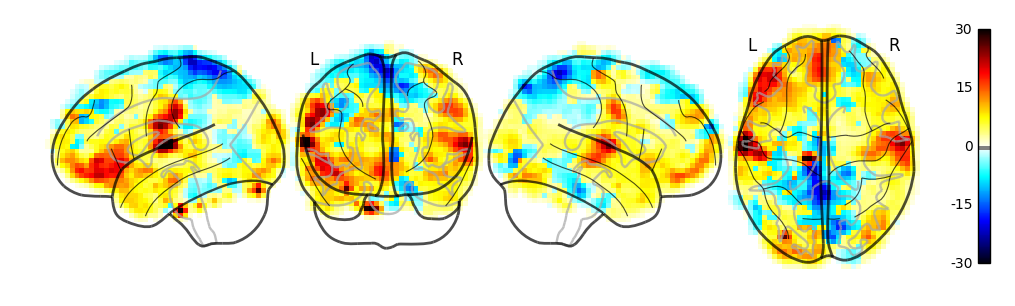

In [110]:
smooth_copes = []
for k,v in copes.items():
    smooth_cope = nilearn.image.smooth_img(v[3], 8)
    smooth_copes.append(smooth_cope)
    nilearn.plotting.plot_glass_brain(smooth_cope,
                                      display_mode='lyrz', 
                                      colorbar=True, 
                                      plot_abs=False, 
                                      vmax=30)

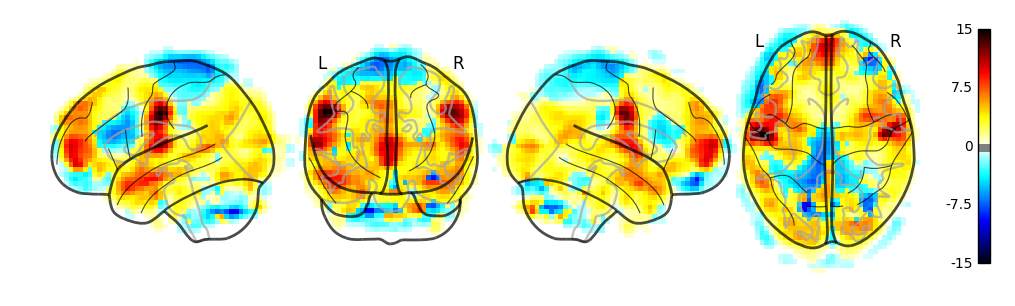

In [111]:
nilearn.plotting.plot_glass_brain(nilearn.image.mean_img(smooth_copes),
                                  display_mode='lyrz', 
                                  colorbar=True, 
                                  plot_abs=False)

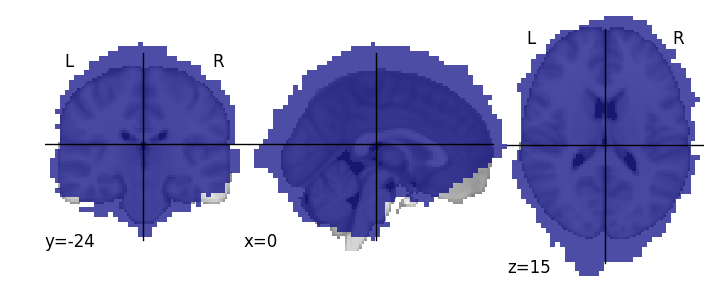

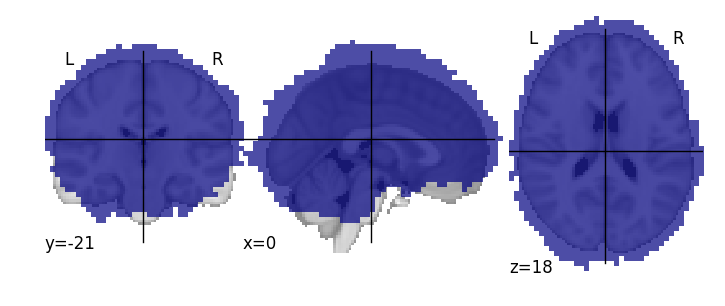

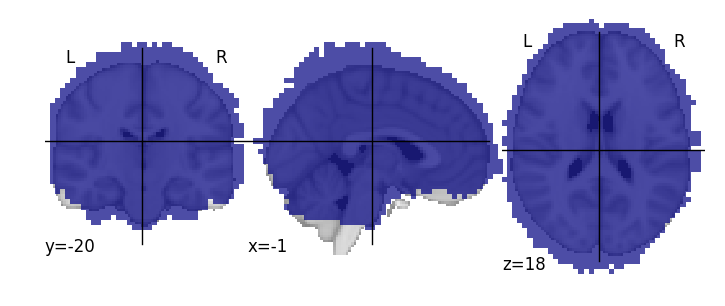

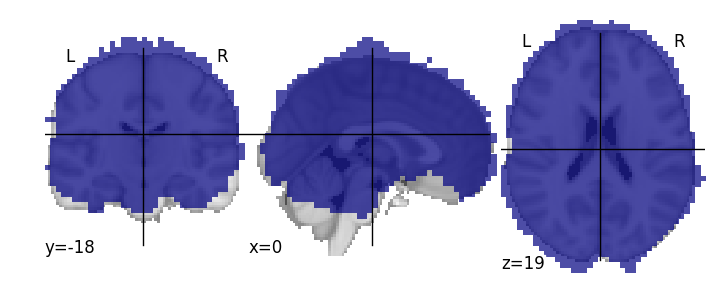

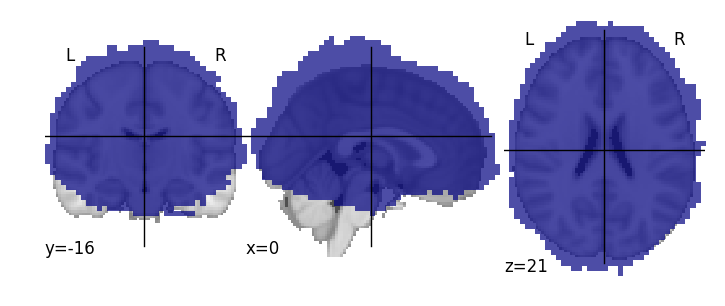

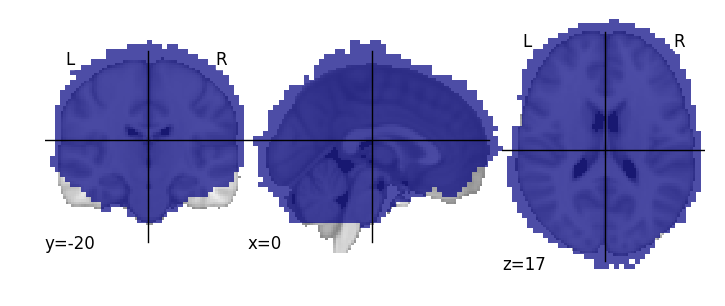

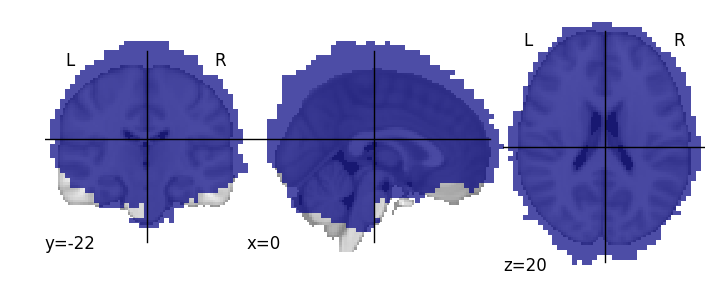

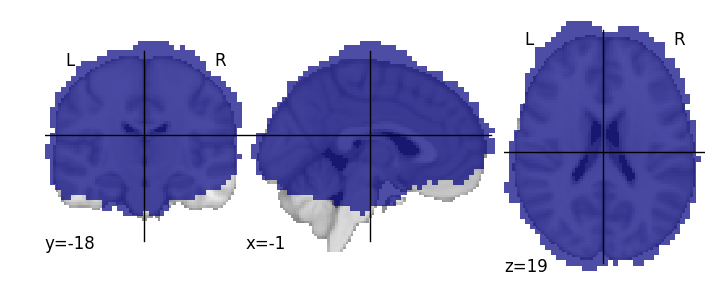

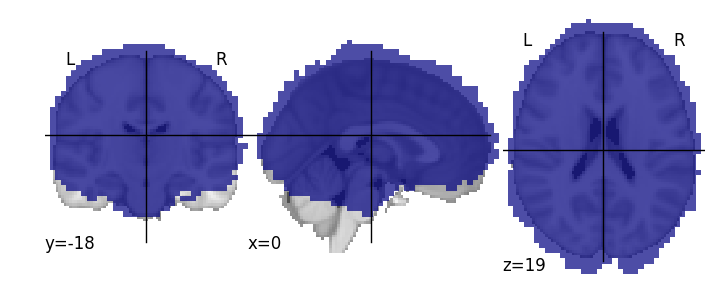

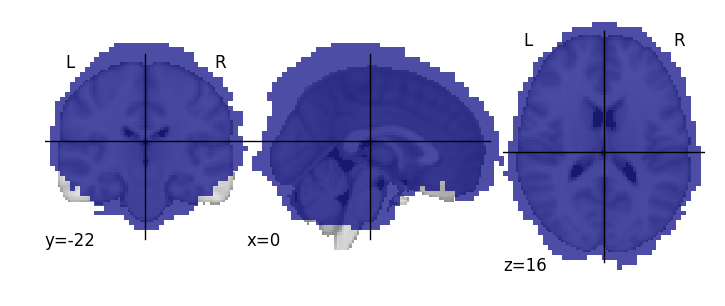

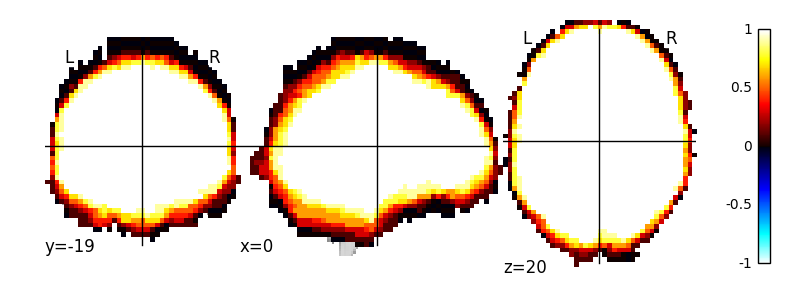

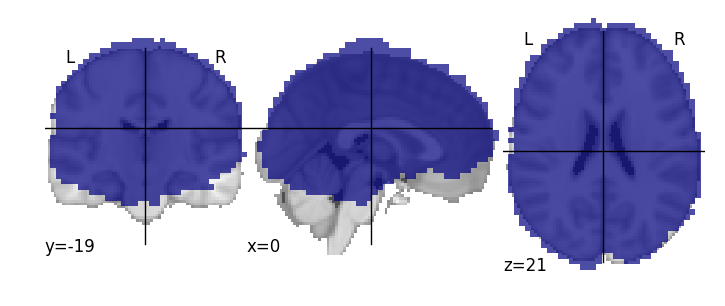

In [112]:
brainmasks = glob.glob(os.path.join(datadir, "derivatives", "fmriprep", "sub-*", "ses-test", "func", "*task-fingerfootlips_*space-MNI152NLin2009cAsym*_brainmask.nii*"))

for mask in brainmasks:
    nilearn.plotting.plot_roi(mask)
    
mean_mask = nilearn.image.mean_img(brainmasks)
nilearn.plotting.plot_stat_map(mean_mask)
group_mask = nilearn.image.math_img("a>=0.95", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)

In [113]:
!mkdir -p {datadir}/derivatives/custom_modelling/

copes_concat = nilearn.image.concat_imgs(smooth_copes, auto_resample=True)
copes_concat.to_filename(os.path.join(datadir, "derivatives", "custom_modelling", "lips_vs_others_copes.nii.gz"))

group_mask = nilearn.image.resample_to_img(group_mask, copes_concat, interpolation='nearest')
group_mask.to_filename(os.path.join(datadir, "derivatives", "custom_modelling", "group_mask.nii.gz"))

/home/vagrant/miniconda3/lib/python3.5/site-packages/nilearn/_utils/niimg_conversions.py:144: UserWarning: Affine is different across subjects. Realignement on first subject affine forced
  warnings.warn('Affine is different across subjects.'


In [114]:
group_mask.shape

(49, 58, 49)

In [115]:
randomise = mem.cache(fsl.Randomise)
randomise_results = randomise(in_file=os.path.join(datadir, "derivatives", "custom_modelling", "lips_vs_others_copes.nii.gz"),
                              mask=os.path.join(datadir, "derivatives", "custom_modelling", "group_mask.nii.gz"),
                              one_sample_group_mean=True,
                              tfce=True,
                              vox_p_values=True,
                              num_perm=500)
randomise_results.outputs

170216-19:49:12,516 workflow INFO:
	 Executing node 393fecf255fa7f15245cd7fa32e0d3c0 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Randomise/393fecf255fa7f15245cd7fa32e0d3c0
170216-19:49:12,534 workflow INFO:
	 Running: randomise -i /media/sf_ds000114_R2.0.1/derivatives/custom_modelling/lips_vs_others_copes.nii.gz -o "tbss_" -m /media/sf_ds000114_R2.0.1/derivatives/custom_modelling/group_mask.nii.gz -n 500 -1 -T -x
170216-19:49:12,585 interface INFO:
	 stdout 2017-02-16T19:49:12.585130:randomise options: -i /media/sf_ds000114_R2.0.1/derivatives/custom_modelling/lips_vs_others_copes.nii.gz -o tbss_ -m /media/sf_ds000114_R2.0.1/derivatives/custom_modelling/group_mask.nii.gz -n 500 -1 -T -x 
170216-19:49:13,89 interface INFO:
	 stdout 2017-02-16T19:49:13.089743:Loading Data: 
170216-19:49:13,90 interface INFO:
	 stdout 2017-02-16T19:49:13.089743:Data loaded
170216-19:49:13,95 interface INFO:
	 stdout 2017-02-16T19:49:13.089743:One-sample


f_corrected_p_files = []
f_p_files = []
fstat_files = []
t_corrected_p_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Randomise/393fecf255fa7f15245cd7fa32e0d3c0/tbss__tfce_corrp_tstat1.nii.gz']
t_p_files = []
tstat_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Randomise/393fecf255fa7f15245cd7fa32e0d3c0/tbss__tstat1.nii.gz']

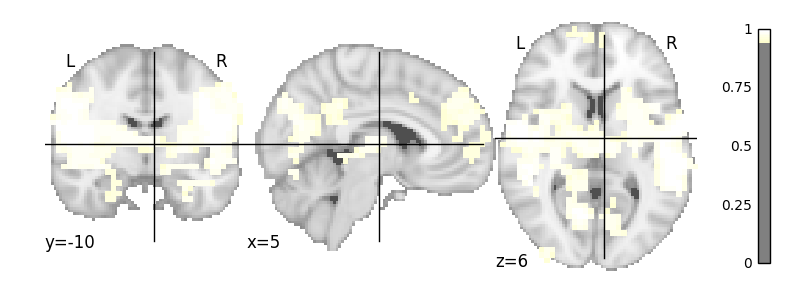

In [116]:
nilearn.plotting.plot_stat_map(randomise_results.outputs.t_corrected_p_files[0], threshold=0.95)

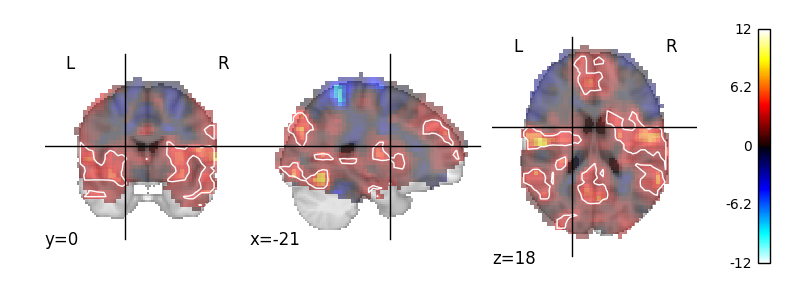

In [117]:
fig = nilearn.plotting.plot_stat_map(randomise_results.outputs.tstat_files[0], alpha=0.5, cut_coords=(-21, 0, 18))
fig.add_contours(randomise_results.outputs.t_corrected_p_files[0], levels=[0.95], colors='w')

In [84]:
nilearn.plotting.plot_stat_map?